# Wine quality analysis - Machine Learning - PART 4

Datasource: https://archive.ics.uci.edu/ml/datasets/wine+quality

## Columns description


Column Position | Atrribute Name | Definition 
 --- | --- | --- 
1 | fixed acidity | most acids involved with wine or fixed or nonvolatile (do not evaporate readily)
2 | volatile acidity | the amount of acetic acid in wine, which at too high of levels can lead to an unpleasant, vinegar taste
3 | citric acid | found in small quantities, citric acid can add 'freshness' and flavor to wines
4 | residual sugar | the amount of sugar remaining after fermentation stops, it's rare to find wines with less than 1 gram/liter and wines with greater than 45 grams/liter are considered sweet
5 | chlorides | the amount of salt in the wine
6 | free sulfur dioxidet | he free form of SO2 exists in equilibrium between molecular SO2 (as a dissolved gas) and bisulfite ion; it prevents microbial growth and the oxidation of wine
7 | total sulfur dioxide | amount of free and bound forms of S02; in low concentrations, SO2 is mostly undetectable in wine, but at free SO2 concentrations over 50 ppm, SO2 becomes evident in the nose and taste of wine
8 | density | the density of water is close to that of water depending on the percent alcohol and sugar content
9 | pH | describes how acidic or basic a wine is on a scale from 0 (very acidic) to 14 (very basic); most wines are between 3-4 on the pH scale
10 | sulphates | a wine additive which can contribute to sulfur dioxide gas (S02) levels, wich acts as an antimicrobial and antioxidant
11 | alcohol | the percent alcohol content of the wine
12 | quality | output variable (based on sensory data, score between 0 and 10)
13 | good | binary evaluation 1 - good , 0 - bad
14 | color | wine type red or white

# Project Plan 

Import libraries <br/>
Data preparation for machine learning<br/>
Linear Support Vector Machine<br/>
Naive Bayes<br/>
Factorization machines classifier<br/>
Decision tree classifier<br/>


# Import libraries 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from datetime import datetime
import numpy as np

#import stats libraries 
from pyspark.mllib.stat import Statistics
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

from pyspark.sql import SparkSession

In [2]:
# May take a little while on a local computer
spark = SparkSession.builder.appName("winequality").getOrCreate()

In [3]:
df = spark.read.csv("winequality.csv",header=True,inferSchema=True)

In [4]:
#df.show(n=2, truncate=False, vertical=True)
df.limit(5).toPandas()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,good,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0,red


In [5]:
#Create DF for red and white wine
df_red = df.filter(df.color =='red')
df_white = df.filter(df.color =='white')

In [6]:
#create lists of categorical and numberical columns

cat = [item[0] for item in df.dtypes if item[1].startswith('string') ]
num = [item for item in df.columns if item not in cat]
print(cat)
print(num)

['color']
['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality', 'good']


# Data preparation for machine learning

In [25]:
#Import libraries
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.ml.evaluation import BinaryClassificationEvaluator

import sklearn 
from sklearn.metrics import classification_report, confusion_matrix

In [8]:
#create input vector
features_column = num[0:-2]

assembler = (VectorAssembler()
  .setInputCols(features_column)
  .setOutputCol("features"))

finalPrep = assembler.transform(df)
#finalPrep.show(n=1, truncate=False, vertical=True)
finalPrep.limit(5).toPandas()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,good,color,features
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0,red,"[7.4, 0.7, 0.0, 1.9, 0.076, 11.0, 34.0, 0.9978..."
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0,red,"[7.8, 0.88, 0.0, 2.6, 0.098, 25.0, 67.0, 0.996..."
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0,red,"[7.8, 0.76, 0.04, 2.3, 0.092, 15.0, 54.0, 0.99..."
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0,red,"[11.2, 0.28, 0.56, 1.9, 0.075, 17.0, 60.0, 0.9..."
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0,red,"[7.4, 0.7, 0.0, 1.9, 0.076, 11.0, 34.0, 0.9978..."


In [9]:
#split in training and testing datasets
training, test = finalPrep.randomSplit([0.7, 0.3])
# Going to cache the data  
training.cache()
test.cache()
print(training.count())
print(test.count())

4600
1897


### Data preparation for machine learning - Red only

In [10]:
#create input vector
features_column = num[0:-2]

assembler_red = (VectorAssembler()
  .setInputCols(features_column)
  .setOutputCol("features"))

finalPrep_red = assembler_red.transform(df_red)
#finalPrep_red.show(n=1, truncate=False, vertical=True)
finalPrep_red.limit(5).toPandas()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,good,color,features
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0,red,"[7.4, 0.7, 0.0, 1.9, 0.076, 11.0, 34.0, 0.9978..."
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0,red,"[7.8, 0.88, 0.0, 2.6, 0.098, 25.0, 67.0, 0.996..."
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0,red,"[7.8, 0.76, 0.04, 2.3, 0.092, 15.0, 54.0, 0.99..."
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0,red,"[11.2, 0.28, 0.56, 1.9, 0.075, 17.0, 60.0, 0.9..."
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0,red,"[7.4, 0.7, 0.0, 1.9, 0.076, 11.0, 34.0, 0.9978..."


In [11]:
#split in training and testing datasets
training_red, test_red = finalPrep_red.randomSplit([0.7, 0.3])
# Going to cache the data  
training_red.cache()
test_red.cache()
print(training_red.count())
print(test_red.count())

1119
480


### Data preparation for machine learning - White only

In [12]:
#create input vector
features_column = num[0:-2]

assembler_white = (VectorAssembler()
  .setInputCols(features_column)
  .setOutputCol("features"))

finalPrep_white = assembler_red.transform(df_white)
#finalPrep_red.show(n=1, truncate=False, vertical=True)
finalPrep_white.limit(5).toPandas()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,good,color,features
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,0,white,"[7.0, 0.27, 0.36, 20.7, 0.045, 45.0, 170.0, 1...."
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,0,white,"[6.3, 0.3, 0.34, 1.6, 0.049, 14.0, 132.0, 0.99..."
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,0,white,"[8.1, 0.28, 0.4, 6.9, 0.05, 30.0, 97.0, 0.9951..."
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,0,white,"[7.2, 0.23, 0.32, 8.5, 0.058, 47.0, 186.0, 0.9..."
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,0,white,"[7.2, 0.23, 0.32, 8.5, 0.058, 47.0, 186.0, 0.9..."


In [13]:
#split in training and testing datasets
training_white, test_white = finalPrep_white.randomSplit([0.7, 0.3])
# Going to cache the data  
training_white.cache()
test_white.cache()
print(training_white.count())
print(test_white.count())

3431
1467


### Encode Wine type and include in the model

In [14]:
cat

['color']

In [15]:
#convert cat data into INT

#define a list of stages in your pipeline. The string indexer will be one stage
stages = []

#iterate through all categorical values
for categoricalCol in cat:
    #create a string indexer for those categorical values and assign a new name including the word 'Index'
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')

    #append the string Indexer to our list of stages
    stages += [stringIndexer]

#Create the pipeline. Assign the satges list to the pipeline key word stages
pipeline = Pipeline(stages = stages)
#fit the pipeline to our dataframe
pipelineModel = pipeline.fit(df)
#transform the dataframe
df_enc= pipelineModel.transform(df)

In [16]:
df_enc.show(n=2, truncate=False, vertical=True)

-RECORD 0----------------------
 fixed acidity        | 7.4    
 volatile acidity     | 0.7    
 citric acid          | 0.0    
 residual sugar       | 1.9    
 chlorides            | 0.076  
 free sulfur dioxide  | 11.0   
 total sulfur dioxide | 34.0   
 density              | 0.9978 
 pH                   | 3.51   
 sulphates            | 0.56   
 alcohol              | 9.4    
 quality              | 5      
 good                 | 0      
 color                | red    
 colorIndex           | 1.0    
-RECORD 1----------------------
 fixed acidity        | 7.8    
 volatile acidity     | 0.88   
 citric acid          | 0.0    
 residual sugar       | 2.6    
 chlorides            | 0.098  
 free sulfur dioxide  | 25.0   
 total sulfur dioxide | 67.0   
 density              | 0.9968 
 pH                   | 3.2    
 sulphates            | 0.68   
 alcohol              | 9.8    
 quality              | 5      
 good                 | 0      
 color                | red    
 colorIn

In [17]:
num_enc = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'colorIndex']
num_enc

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'colorIndex']

In [18]:
#create input vector
features_column = num_enc

assembler = (VectorAssembler()
  .setInputCols(features_column)
  .setOutputCol("features"))

finalPrep = assembler.transform(df_enc)
finalPrep.show(n=1, truncate=False, vertical=True)

-RECORD 0--------------------------------------------------------------------------
 fixed acidity        | 7.4                                                        
 volatile acidity     | 0.7                                                        
 citric acid          | 0.0                                                        
 residual sugar       | 1.9                                                        
 chlorides            | 0.076                                                      
 free sulfur dioxide  | 11.0                                                       
 total sulfur dioxide | 34.0                                                       
 density              | 0.9978                                                     
 pH                   | 3.51                                                       
 sulphates            | 0.56                                                       
 alcohol              | 9.4                                                 

In [19]:
#split in training and testing datasets
training_enc, test_enc = finalPrep.randomSplit([0.7, 0.3])
# Going to cache the data  
training_enc.cache()
test_enc.cache()
print(training_enc.count())
print(test_enc.count())

4545
1952


# Linear Support Vector Machine

In [20]:
from pyspark.ml.classification import LinearSVC

In [21]:
def LSVMClassifer(training, test):
    model = (LinearSVC()
      .setLabelCol("good")
      .setFeaturesCol("features"))
    paramGrid = (ParamGridBuilder()
      .addGrid(model.maxIter, [10])
      .addGrid(model.regParam, [0.1])
      .build())

    stages = [model] 
    pipeline = Pipeline().setStages(stages)
    
    cv = (CrossValidator() # you can feel free to change the number of folds used in cross validation as well
      .setEstimator(pipeline) # the estimator can also just be an individual model rather than a pipeline
      .setEstimatorParamMaps(paramGrid)
      .setEvaluator(BinaryClassificationEvaluator().setLabelCol("good")))
    
    pipelineFitted = cv.fit(training)
    
    print("The Best Parameters:\n--------------------")
    print(pipelineFitted.bestModel.stages[0])      
    pipelineFitted.bestModel.stages[0].extractParamMap()
    
    test_predict = pipelineFitted.bestModel.transform(test).selectExpr("double(round(prediction)) as prediction","double(round(good)) as good")
    display(test_predict.show(3))
    
    return test_predict

In [22]:
def ConfMatrix(test_predict):
        #collect prediction and true value
    y_true = test_predict.select(['good']).collect()
    y_pred = test_predict.select(['prediction']).collect()

    #classification report
    print(classification_report(y_true, y_pred))
    
    #confusion matrix 

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.show()

In [23]:
def Evaluation(test_predict):
    acc = test_predict.selectExpr("prediction", "good",
                        """
                        CASE prediction = good
                        WHEN true then 1
                        ELSE 0
                        END as equal
                        """)
        
    print(acc.selectExpr("sum(equal)/sum(1)").show())

    # Another way to evaluate error
    evaluator = MulticlassClassificationEvaluator(labelCol="good", predictionCol="prediction", metricName="accuracy")
    
    accuracy = evaluator.evaluate(test_predict)
    print("Test Error = %g" % (1.0 - accuracy))
    
    ConfMatrix(test_predict)

### Linear Support Vector Machine - all wine

The Best Parameters:
--------------------
LinearSVCModel: uid=LinearSVC_f86653439099, numClasses=2, numFeatures=12
+----------+----+
|prediction|good|
+----------+----+
|       0.0| 1.0|
|       0.0| 0.0|
|       0.0| 0.0|
+----------+----+
only showing top 3 rows



None

+---------------------+
|(sum(equal) / sum(1))|
+---------------------+
|   0.8002049180327869|
+---------------------+

None
Test Error = 0.199795


/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.80      1.00      0.89      1562
         1.0       0.00      0.00      0.00       390

    accuracy                           0.80      1952
   macro avg       0.40      0.50      0.44      1952
weighted avg       0.64      0.80      0.71      1952



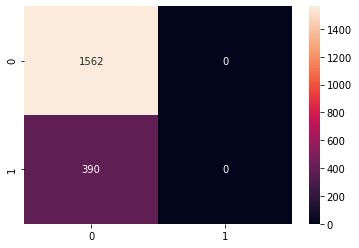

In [26]:
test_predict = LSVMClassifer(training_enc, test_enc)
Evaluation(test_predict)

### Linear Support Vector Machine - red wine

The Best Parameters:
--------------------
LinearSVCModel: uid=LinearSVC_1e2a6fb6d976, numClasses=2, numFeatures=11
+----------+----+
|prediction|good|
+----------+----+
|       0.0| 0.0|
|       0.0| 1.0|
|       0.0| 1.0|
+----------+----+
only showing top 3 rows



None

+---------------------+
|(sum(equal) / sum(1))|
+---------------------+
|   0.8604166666666667|
+---------------------+

None
Test Error = 0.139583
              precision    recall  f1-score   support

         0.0       0.86      1.00      0.92       413
         1.0       0.00      0.00      0.00        67

    accuracy                           0.86       480
   macro avg       0.43      0.50      0.46       480
weighted avg       0.74      0.86      0.80       480



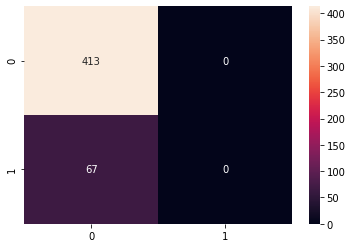

In [27]:
test_predict = LSVMClassifer(training_red, test_red)
Evaluation(test_predict)

### Linear Support Vector Machine - whte wine

The Best Parameters:
--------------------
LinearSVCModel: uid=LinearSVC_7647709c6f45, numClasses=2, numFeatures=11
+----------+----+
|prediction|good|
+----------+----+
|       0.0| 1.0|
|       0.0| 1.0|
|       0.0| 0.0|
+----------+----+
only showing top 3 rows



None

+---------------------+
|(sum(equal) / sum(1))|
+---------------------+
|   0.7791411042944786|
+---------------------+

None
Test Error = 0.220859
              precision    recall  f1-score   support

         0.0       0.78      1.00      0.88      1143
         1.0       0.00      0.00      0.00       324

    accuracy                           0.78      1467
   macro avg       0.39      0.50      0.44      1467
weighted avg       0.61      0.78      0.68      1467



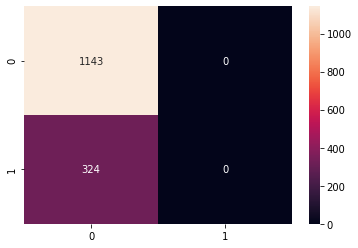

In [28]:
test_predict = LSVMClassifer(training_white, test_white)
Evaluation(test_predict)

# Naive Bayes

In [29]:
from pyspark.ml.classification import NaiveBayes

In [30]:
def NBClassifer(training, test):
    model = (NaiveBayes()
      .setLabelCol("good")
      .setFeaturesCol("features"))
    paramGrid = (ParamGridBuilder()
      .addGrid(model.smoothing, [0.1])
      .addGrid(model.modelType, ["multinomial"])
      .build())

    stages = [model] 
    pipeline = Pipeline().setStages(stages)
    
    cv = (CrossValidator() # you can feel free to change the number of folds used in cross validation as well
      .setEstimator(pipeline) # the estimator can also just be an individual model rather than a pipeline
      .setEstimatorParamMaps(paramGrid)
      .setEvaluator(BinaryClassificationEvaluator().setLabelCol("good")))
    
    pipelineFitted = cv.fit(training)
    
    print("The Best Parameters:\n--------------------")
    print(pipelineFitted.bestModel.stages[0])      
    pipelineFitted.bestModel.stages[0].extractParamMap()
    
    test_predict = pipelineFitted.bestModel.transform(test).selectExpr("double(round(prediction)) as prediction","double(round(good)) as good")
    display(test_predict.show(3))
    
    return test_predict

### Naive Bayes classifier - all wine

The Best Parameters:
--------------------
NaiveBayesModel: uid=NaiveBayes_a3ad2d10054a, modelType=multinomial, numClasses=2, numFeatures=12
+----------+----+
|prediction|good|
+----------+----+
|       0.0| 1.0|
|       0.0| 0.0|
|       0.0| 0.0|
+----------+----+
only showing top 3 rows



None

+---------------------+
|(sum(equal) / sum(1))|
+---------------------+
|   0.7802254098360656|
+---------------------+

None
Test Error = 0.219775
              precision    recall  f1-score   support

         0.0       0.81      0.94      0.87      1562
         1.0       0.36      0.13      0.20       390

    accuracy                           0.78      1952
   macro avg       0.59      0.54      0.53      1952
weighted avg       0.72      0.78      0.74      1952



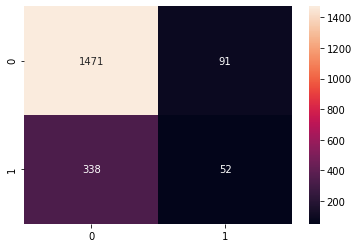

In [31]:
test_predict = NBClassifer(training_enc, test_enc)
Evaluation(test_predict)

### Naive Bayes classifier - red wine

The Best Parameters:
--------------------
NaiveBayesModel: uid=NaiveBayes_c03b4c4baaff, modelType=multinomial, numClasses=2, numFeatures=11
+----------+----+
|prediction|good|
+----------+----+
|       0.0| 0.0|
|       0.0| 1.0|
|       0.0| 1.0|
+----------+----+
only showing top 3 rows



None

+---------------------+
|(sum(equal) / sum(1))|
+---------------------+
|   0.6583333333333333|
+---------------------+

None
Test Error = 0.341667
              precision    recall  f1-score   support

         0.0       0.90      0.68      0.77       413
         1.0       0.21      0.51      0.29        67

    accuracy                           0.66       480
   macro avg       0.55      0.60      0.53       480
weighted avg       0.80      0.66      0.71       480



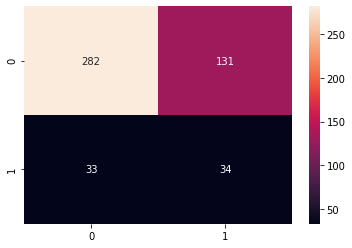

In [32]:
test_predict = NBClassifer(training_red, test_red)
Evaluation(test_predict)

### Naive Bayes classifier - white wine

The Best Parameters:
--------------------
NaiveBayesModel: uid=NaiveBayes_6e09c9c1ea3e, modelType=multinomial, numClasses=2, numFeatures=11
+----------+----+
|prediction|good|
+----------+----+
|       1.0| 1.0|
|       0.0| 1.0|
|       0.0| 0.0|
+----------+----+
only showing top 3 rows



None

+---------------------+
|(sum(equal) / sum(1))|
+---------------------+
|    0.732788002726653|
+---------------------+

None
Test Error = 0.267212
              precision    recall  f1-score   support

         0.0       0.81      0.86      0.83      1143
         1.0       0.37      0.29      0.32       324

    accuracy                           0.73      1467
   macro avg       0.59      0.57      0.58      1467
weighted avg       0.71      0.73      0.72      1467



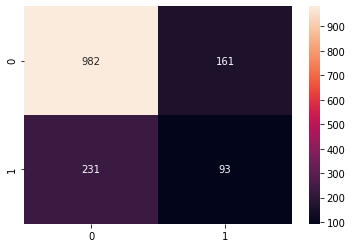

In [33]:
test_predict = NBClassifer(training_white, test_white)
Evaluation(test_predict)

# Factorization machines classifier

In [34]:
from pyspark.ml.classification import FMClassifier

In [35]:
def FMClassifer(training, test):
    model = (FMClassifier()
      .setLabelCol("good")
      .setFeaturesCol("features"))
    paramGrid = (ParamGridBuilder()
      .addGrid(model.stepSize, [0.001])
      .build())

    stages = [model] 
    pipeline = Pipeline().setStages(stages)
    
    cv = (CrossValidator() # you can feel free to change the number of folds used in cross validation as well
      .setEstimator(pipeline) # the estimator can also just be an individual model rather than a pipeline
      .setEstimatorParamMaps(paramGrid)
      .setEvaluator(BinaryClassificationEvaluator().setLabelCol("good")))
    
    pipelineFitted = cv.fit(training)
    
    print("The Best Parameters:\n--------------------")
    print(pipelineFitted.bestModel.stages[0])      
    pipelineFitted.bestModel.stages[0].extractParamMap()
    
    test_predict = pipelineFitted.bestModel.transform(test).selectExpr("double(round(prediction)) as prediction","double(round(good)) as good")
    display(test_predict.show(3))
    
    return test_predict

### Factorization machines classifier - all wine

The Best Parameters:
--------------------
FMClassificationModel: uid=FMClassifier_2975cccf74ee, numClasses=2, numFeatures=12, factorSize=8, fitLinear=true, fitIntercept=true
+----------+----+
|prediction|good|
+----------+----+
|       0.0| 1.0|
|       0.0| 0.0|
|       0.0| 0.0|
+----------+----+
only showing top 3 rows



None

+---------------------+
|(sum(equal) / sum(1))|
+---------------------+
|   0.8002049180327869|
+---------------------+

None
Test Error = 0.199795
              precision    recall  f1-score   support

         0.0       0.80      1.00      0.89      1562
         1.0       0.00      0.00      0.00       390

    accuracy                           0.80      1952
   macro avg       0.40      0.50      0.44      1952
weighted avg       0.64      0.80      0.71      1952



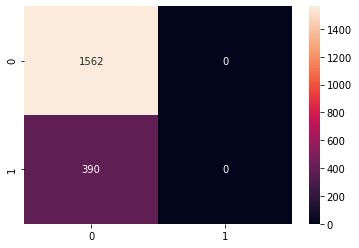

In [36]:
test_predict = FMClassifer(training_enc, test_enc)
Evaluation(test_predict)

### Factorization machines classifier - red wine

The Best Parameters:
--------------------
FMClassificationModel: uid=FMClassifier_e5127ba51c97, numClasses=2, numFeatures=11, factorSize=8, fitLinear=true, fitIntercept=true
+----------+----+
|prediction|good|
+----------+----+
|       0.0| 0.0|
|       0.0| 1.0|
|       0.0| 1.0|
+----------+----+
only showing top 3 rows



None

+---------------------+
|(sum(equal) / sum(1))|
+---------------------+
|   0.8604166666666667|
+---------------------+

None
Test Error = 0.139583
              precision    recall  f1-score   support

         0.0       0.86      1.00      0.92       413
         1.0       0.00      0.00      0.00        67

    accuracy                           0.86       480
   macro avg       0.43      0.50      0.46       480
weighted avg       0.74      0.86      0.80       480



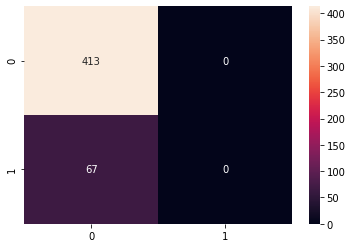

In [37]:
test_predict = FMClassifer(training_red, test_red)
Evaluation(test_predict)

### Factorization machines classifier - white wine

The Best Parameters:
--------------------
FMClassificationModel: uid=FMClassifier_be17c38b058e, numClasses=2, numFeatures=11, factorSize=8, fitLinear=true, fitIntercept=true
+----------+----+
|prediction|good|
+----------+----+
|       0.0| 1.0|
|       0.0| 1.0|
|       0.0| 0.0|
+----------+----+
only showing top 3 rows



None

+---------------------+
|(sum(equal) / sum(1))|
+---------------------+
|   0.7791411042944786|
+---------------------+

None
Test Error = 0.220859
              precision    recall  f1-score   support

         0.0       0.78      1.00      0.88      1143
         1.0       0.00      0.00      0.00       324

    accuracy                           0.78      1467
   macro avg       0.39      0.50      0.44      1467
weighted avg       0.61      0.78      0.68      1467



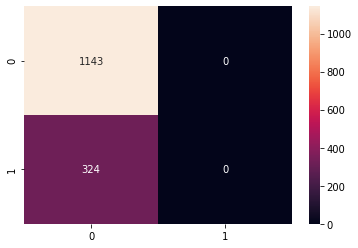

In [38]:
test_predict = FMClassifer(training_white, test_white)
Evaluation(test_predict)

# Decision tree classifier 

In [39]:
from pyspark.ml.classification import DecisionTreeClassifier

In [40]:
print(DecisionTreeClassifier().explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featuresCol: features column name. (default: features)
impurity: Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini (default: gini)
labelCol: label column name. (default: label)
leafCol: Leaf indices column name. Predicted leaf index of each instance in each tree by preorder. (default: )
maxBins: Max number of bins for discretizing continuous features.  Must be 

In [41]:
def DTClassifer(training, test):
    rfModel = (DecisionTreeClassifier()
      .setLabelCol("good")
      .setFeaturesCol("features"))
    paramGrid = (ParamGridBuilder()
      .addGrid(rfModel.maxDepth, [5, 10, 20])
      .build())

    stages = [rfModel]
    pipeline = Pipeline().setStages(stages)
    
    cv = (CrossValidator() # you can feel free to change the number of folds used in cross validation as well
      .setEstimator(pipeline) # the estimator can also just be an individual model rather than a pipeline
      .setEstimatorParamMaps(paramGrid)
      .setEvaluator(BinaryClassificationEvaluator().setLabelCol("good")))
    
    pipelineFitted = cv.fit(training)
    
    print("The Best Parameters:\n--------------------")
    print(pipelineFitted.bestModel.stages[0])      
    pipelineFitted.bestModel.stages[0].extractParamMap()
    
    test_predict = pipelineFitted.bestModel.transform(test).selectExpr("double(round(prediction)) as prediction","double(round(good)) as good")
    display(test_predict.show(3))
    
    return test_predict

### Decision tree classifier - all wine

The Best Parameters:
--------------------
DecisionTreeClassificationModel: uid=DecisionTreeClassifier_42631f9969a6, depth=20, numNodes=1063, numClasses=2, numFeatures=12
+----------+----+
|prediction|good|
+----------+----+
|       0.0| 1.0|
|       0.0| 0.0|
|       1.0| 0.0|
+----------+----+
only showing top 3 rows



None

+---------------------+
|(sum(equal) / sum(1))|
+---------------------+
|   0.8345286885245902|
+---------------------+

None
Test Error = 0.165471
              precision    recall  f1-score   support

         0.0       0.91      0.88      0.90      1562
         1.0       0.58      0.64      0.61       390

    accuracy                           0.83      1952
   macro avg       0.74      0.76      0.75      1952
weighted avg       0.84      0.83      0.84      1952



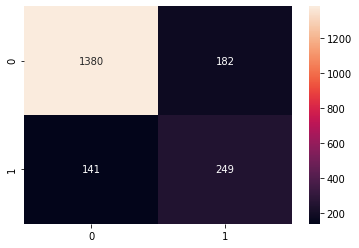

In [42]:
test_predict = DTClassifer(training_enc, test_enc)
Evaluation(test_predict)

### Decision tree classifier - red wine

The Best Parameters:
--------------------
DecisionTreeClassificationModel: uid=DecisionTreeClassifier_fec809cb1f0b, depth=10, numNodes=199, numClasses=2, numFeatures=11
+----------+----+
|prediction|good|
+----------+----+
|       0.0| 0.0|
|       1.0| 1.0|
|       1.0| 1.0|
+----------+----+
only showing top 3 rows



None

+---------------------+
|(sum(equal) / sum(1))|
+---------------------+
|   0.8770833333333333|
+---------------------+

None
Test Error = 0.122917
              precision    recall  f1-score   support

         0.0       0.92      0.93      0.93       413
         1.0       0.56      0.52      0.54        67

    accuracy                           0.88       480
   macro avg       0.74      0.73      0.74       480
weighted avg       0.87      0.88      0.88       480



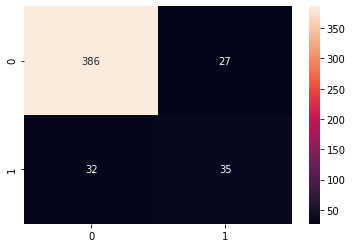

In [43]:
test_predict = DTClassifer(training_red, test_red)
Evaluation(test_predict)

### Decision tree classifier - white wine

The Best Parameters:
--------------------
DecisionTreeClassificationModel: uid=DecisionTreeClassifier_fb07661fc1bd, depth=10, numNodes=461, numClasses=2, numFeatures=11
+----------+----+
|prediction|good|
+----------+----+
|       1.0| 1.0|
|       0.0| 1.0|
|       1.0| 0.0|
+----------+----+
only showing top 3 rows



None

+---------------------+
|(sum(equal) / sum(1))|
+---------------------+
|   0.8227675528289026|
+---------------------+

None
Test Error = 0.177232
              precision    recall  f1-score   support

         0.0       0.88      0.90      0.89      1143
         1.0       0.61      0.56      0.58       324

    accuracy                           0.82      1467
   macro avg       0.74      0.73      0.73      1467
weighted avg       0.82      0.82      0.82      1467



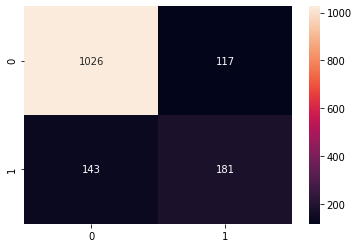

In [44]:
test_predict = DTClassifer(training_white, test_white)
Evaluation(test_predict)